# ĐỀ BÀI

1. What are the patterns/behavior of churned users? What are your suggestions to the company to reduce churned users

2. Build the Machine Learning model for predicting churned users. (fine tuning)


3. Based on the behaviors of churned users, the company would like to offer some special promotions for them.
Please segment these churned users into groups. What are the differences between groups?

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Preprocessing
from scipy import stats #skewness reduction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE

### Supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score

### Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Unsupervised learning
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df = pd.read_excel('/content/drive/MyDrive/D.A/Machine Learning/Final Project nháp/churn_prediction.xlsx')

In [3]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


## **1. EDA**

#### **1.1 Overview**

In [4]:
def overview(df):
  print(df.shape)
  print('\n')
  print(df.info())

In [5]:
overview(df)

(5630, 20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  Numbe

=> Datatype:
- `Tenure` convert float to int
- `WearhouseToHome`convert float to int
- `CouponUsed` convert float to int
- `OrderCount` convert float to int
- `DaySinceLastOrder` convert float to int

=> Missing vals: `Tenure`,`WarehouseToHome`,`HourSpendOnApp`,`OrderAmountHikeFromlastYear`,`CouponUsed`,`OrderCount`,`DaySinceLastOrder`

In [6]:
df.head(2)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90


#### **1.2 Check missing values + duplicated values**

In [7]:
df.isnull().sum()

,0
CustomerID,0
Churn,0
Tenure,264
PreferredLoginDevice,0
CityTier,0
WarehouseToHome,251
PreferredPaymentMode,0
Gender,0
HourSpendOnApp,255
NumberOfDeviceRegistered,0


In [8]:
df.duplicated().sum()

0

In [9]:
df["CustomerID"].duplicated().sum()

0

#### **1.3 Fill missing values**: median hoặc 0

Tenure                         float64
WarehouseToHome                float64
HourSpendOnApp                 float64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
dtype: object


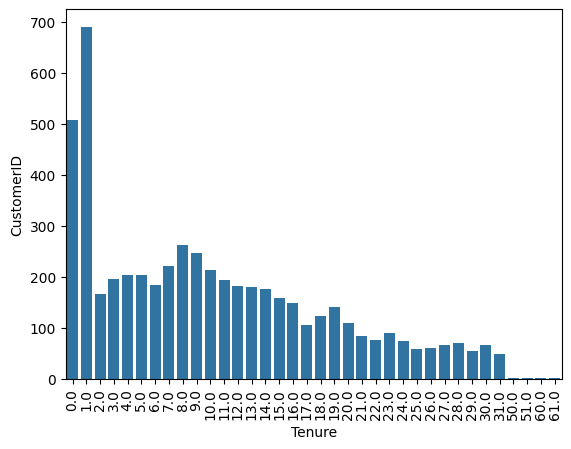

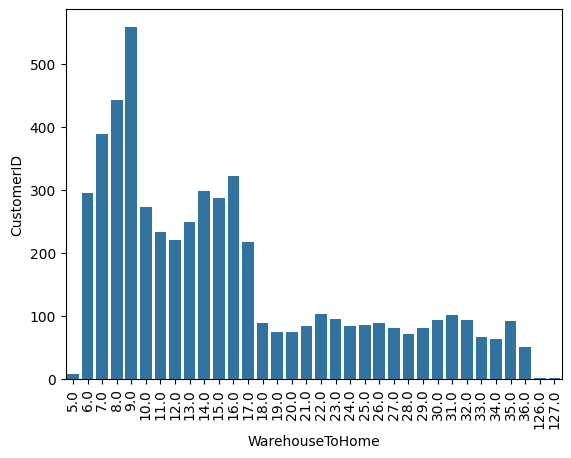

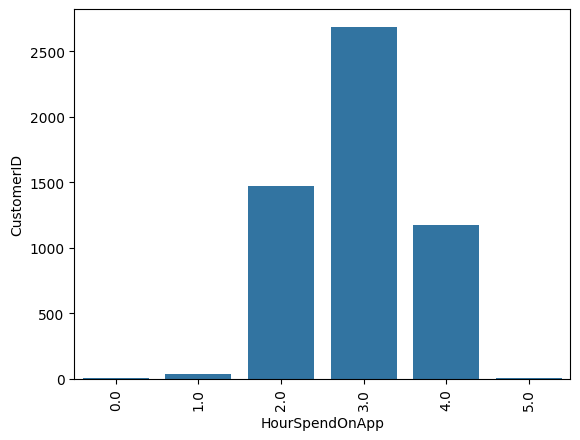

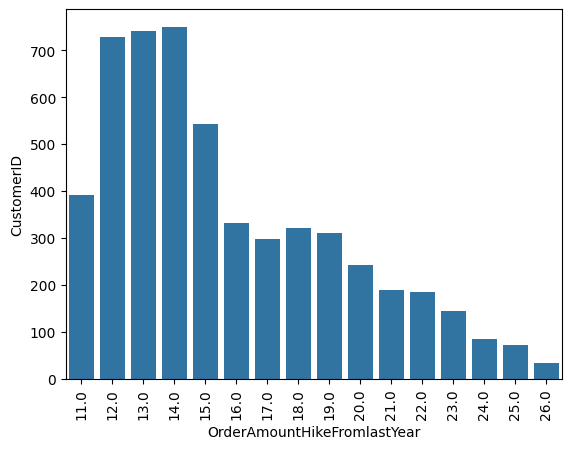

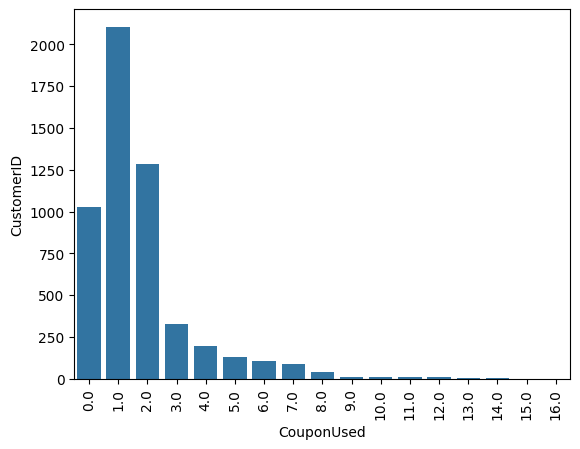

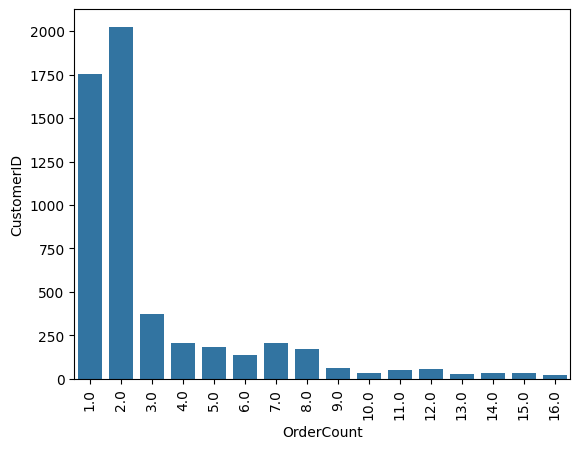

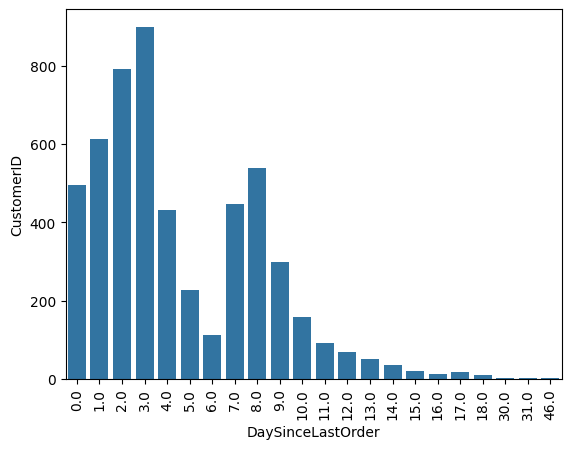

In [10]:
list_missing = df.columns[df.isnull().any()].tolist()
print(df[list_missing].dtypes)

for i in list_missing:
  pivot = df.groupby(i)["CustomerID"].agg('count').reset_index()
  sns.barplot(pivot, x=pivot[i], y=pivot['CustomerID'])
  plt.xticks(rotation=90)
  plt.show()

Sau khi quan sát distribution và ý nghĩa của các missing columns thì fill missing value như sau:
- `Tenure`: median
- `WarehousetoHome`: median
- `HourSpendOnApp`: 0
- `OrderAmountHikeFromlastYear`: median
- `CouponUsed`: 0
- `OrderCount`: median
- `DaySinceLastOrder`: median

In [11]:
def fill_missing(df):
  for i in list_missing:
    if i in ['Tenure','WarehouseToHome', 'OrderAmountHikeFromLastYear','OrderCount','DaySinceLastOrder']:
      df[i] = df[i].fillna(df[i].median())
    else:
      df[i] = df[i].fillna(0)

fill_missing(df)
df.isnull().sum()

,0
CustomerID,0
Churn,0
Tenure,0
PreferredLoginDevice,0
CityTier,0
WarehouseToHome,0
PreferredPaymentMode,0
Gender,0
HourSpendOnApp,0
NumberOfDeviceRegistered,0


- `Tenure`, `WearhouseToHome`, `HourSpendOnApp`, `CouponUsed`, `OrderAmountHikeFromlastYear`, `OrderCount`, `DaySinceLastOrder`, `CashbackAmount` convert float to int

In [12]:
def convert_int(df,array):
  for col in array:
    df[col] = df[df[col].notnull()][col].astype(int)

array_convert = ['Tenure','WarehouseToHome','CouponUsed','OrderCount','DaySinceLastOrder','CashbackAmount','OrderAmountHikeFromlastYear','HourSpendOnApp']
convert_int(df,array_convert)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   CustomerID                   5630 non-null   int64 
 1   Churn                        5630 non-null   int64 
 2   Tenure                       5630 non-null   int64 
 3   PreferredLoginDevice         5630 non-null   object
 4   CityTier                     5630 non-null   int64 
 5   WarehouseToHome              5630 non-null   int64 
 6   PreferredPaymentMode         5630 non-null   object
 7   Gender                       5630 non-null   object
 8   HourSpendOnApp               5630 non-null   int64 
 9   NumberOfDeviceRegistered     5630 non-null   int64 
 10  PreferedOrderCat             5630 non-null   object
 11  SatisfactionScore            5630 non-null   int64 
 12  MaritalStatus                5630 non-null   object
 13  NumberOfAddress              5630

#### **1.4 Check same meaning values**
- `PreferredLoginDevice` có 2 giá trị trùng ý nghĩa: 'Phone' và 'Mobile Phone'
- `PreferredPaymentMode` có 4 giá trị trùng ý nghĩa: 'CC' và 'Credit Card'; 'COD' và 'Cash on Delivery'
- `PreferredOrderCat` có 2 giá trị trùng ý nghĩa: 'Mobile' và 'Mobile Phone'

In [13]:
# CHECK VALUE IN EACH COLUMN
cols = list(df.columns)
for i in cols:
  print(i)
  print(df[i].unique())
  print("--------------------------------------------------------------------")

CustomerID
[50001 50002 50003 ... 55628 55629 55630]
--------------------------------------------------------------------
Churn
[1 0]
--------------------------------------------------------------------
Tenure
[ 4  9  0 13 11 19 20 14  8 18  5  2 30  1 23  3 29  6 26 28  7 24 25 10
 15 22 27 16 12 21 17 50 60 31 51 61]
--------------------------------------------------------------------
PreferredLoginDevice
['Mobile Phone' 'Phone' 'Computer']
--------------------------------------------------------------------
CityTier
[3 1 2]
--------------------------------------------------------------------
WarehouseToHome
[  6   8  30  15  12  22  11   9  31  18  13  20  29  28  26  14  10  27
  17  23  33  19  35  24  16  25  32  34   5  21 126   7  36 127]
--------------------------------------------------------------------
PreferredPaymentMode
['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
--------------------------------------------------------------------
Gender
[

In [14]:
# FIX SAME MEANINGFUL VALUE
df.loc[df["PreferredLoginDevice"]=="Mobile Phone",["PreferredLoginDevice"]] = "Phone"
df.loc[df["PreferredPaymentMode"]=="Credit Card",["PreferredPaymentMode"]] = "CC"
df.loc[df["PreferredPaymentMode"]=='Cash on Delivery',["PreferredPaymentMode"]] = "COD"
df.loc[df["PreferedOrderCat"]=="Mobile Phone",["PreferedOrderCat"]] = "Mobile"

#### **1.5 Check imbalance data**: có hiện tượng imbalance data

Churn
0    4682
1     948
Name: count, dtype: int64


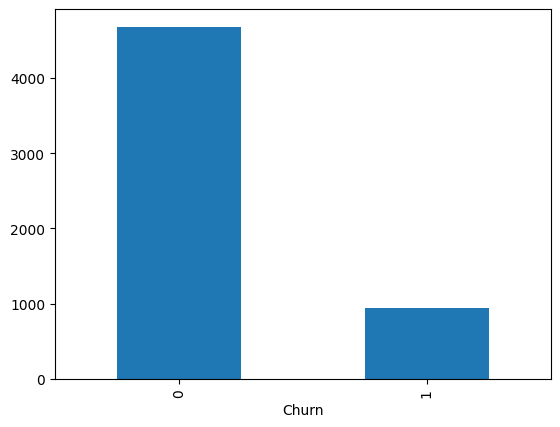

In [15]:
def check_imbalance(df,target_col):
  pivot = df[target_col].value_counts()
  print(pivot)
  pivot.plot(kind='bar')

check_imbalance(df,'Churn')

=> Có hiện tượng imbalance data

#### **1.6 Check skewness, correlation for numerical columns**

In [16]:
false_nume = ['Churn','CityTier','CustomerID']
nume_cols = df.drop(columns=false_nume).select_dtypes('number').columns
cate_cols = df.select_dtypes('object').columns
print('----------False Numerical----------')
print(false_nume)
print('\n')
print('----------Numerical----------')
print(nume_cols.values)
print('\n')
print('----------Categorical----------')
print(cate_cols.values)

----------False Numerical----------
['Churn', 'CityTier', 'CustomerID']


----------Numerical----------
['Tenure' 'WarehouseToHome' 'HourSpendOnApp' 'NumberOfDeviceRegistered'
 'SatisfactionScore' 'NumberOfAddress' 'Complain'
 'OrderAmountHikeFromlastYear' 'CouponUsed' 'OrderCount'
 'DaySinceLastOrder' 'CashbackAmount']


----------Categorical----------
['PreferredLoginDevice' 'PreferredPaymentMode' 'Gender' 'PreferedOrderCat'
 'MaritalStatus']


In [17]:
df[nume_cols].describe()

,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000
mean,10.134103,15.566785,2.798757,3.688988,3.066785,4.214032,0.284902,14.968561,1.671403,2.961812,4.459325,176.733393
std,8.357951,8.345961,0.932334,1.023999,1.380194,2.583586,0.451408,4.893091,1.886648,2.879248,3.570626,49.209149
min,0.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.000000
50%,9.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,14.000000,1.000000,2.000000,3.000000,163.000000
75%,15.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000
max,61.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.000000


##### **CHECK SKEWNESS**: numerical columns do not have bell-shaped data => this can affect learning ability of model or assumption of model

In [18]:
def check_skewness(df,nume_cols):
  for x in nume_cols:
    print(f'Skewness of {x}: ',df[x].skew().round(2))

check_skewness(df,nume_cols)

Skewness of Tenure:  0.77
Skewness of WarehouseToHome:  1.68
Skewness of HourSpendOnApp:  -0.99
Skewness of NumberOfDeviceRegistered:  -0.4
Skewness of SatisfactionScore:  -0.14
Skewness of NumberOfAddress:  1.09
Skewness of Complain:  0.95
Skewness of OrderAmountHikeFromlastYear:  -0.78
Skewness of CouponUsed:  2.55
Skewness of OrderCount:  2.28
Skewness of DaySinceLastOrder:  1.27
Skewness of CashbackAmount:  1.15


##### **CHECK CORRELATION**: high correlation between `OrderCount` & `CouponUsed`, `DaySinceLastOrder` & `CashbackAmount`

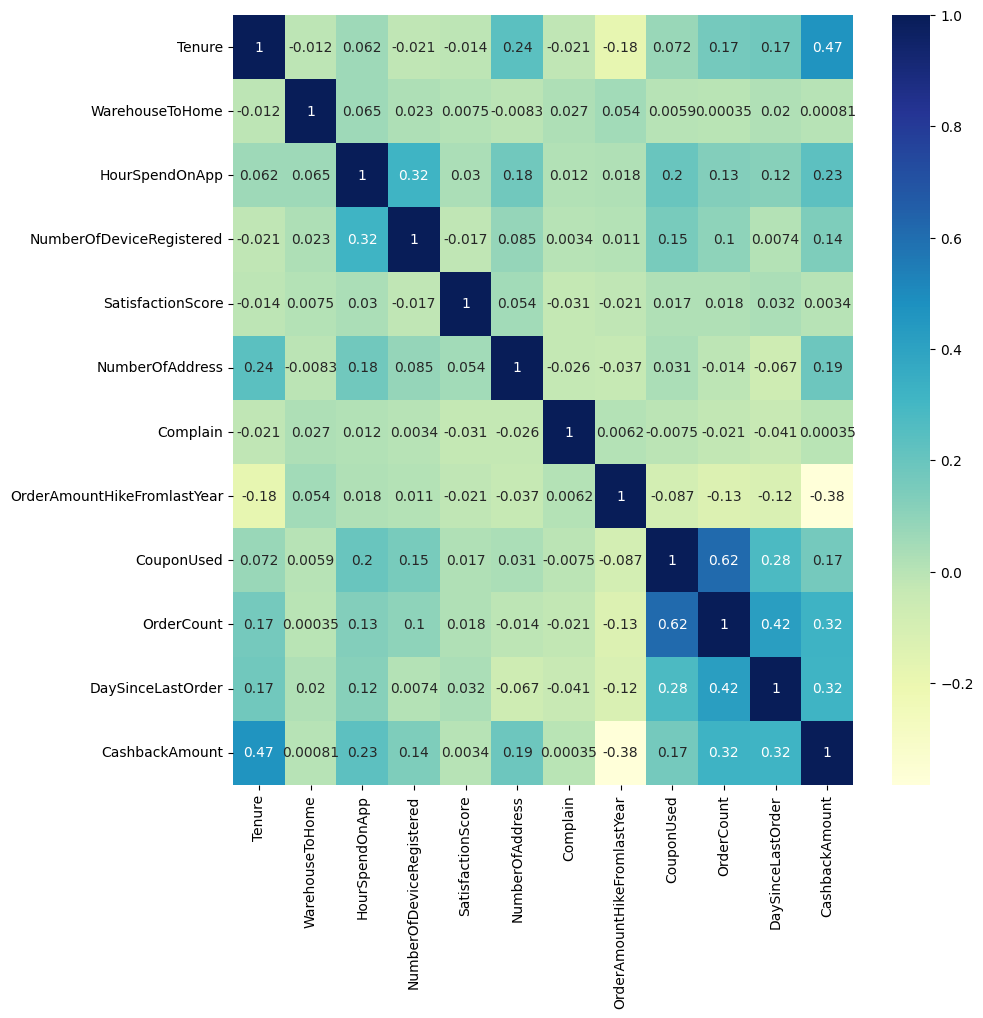

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(df[nume_cols].corr(), annot=True, cmap='YlGnBu')
plt.show()

##### **CHECK OUTLIER**: most columns have outliers

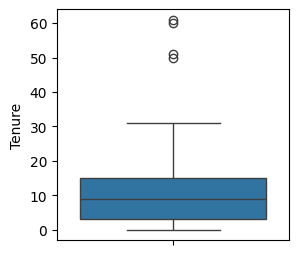

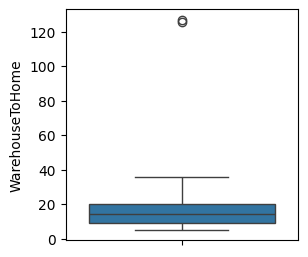

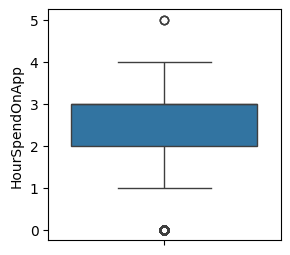

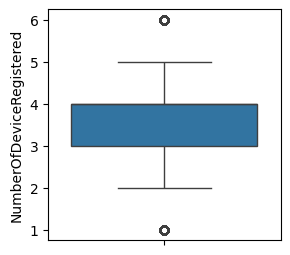

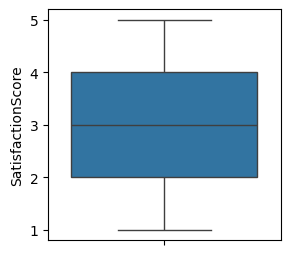

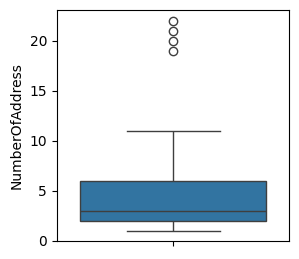

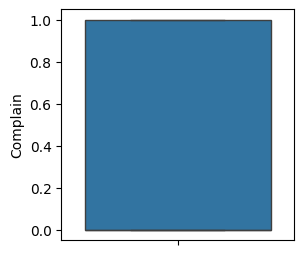

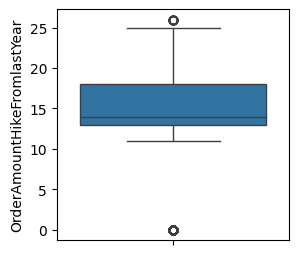

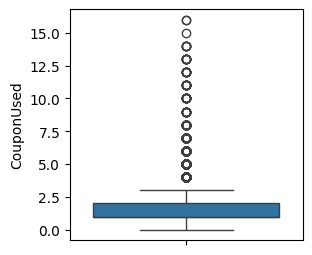

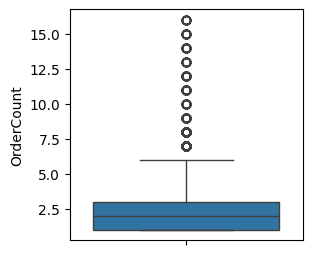

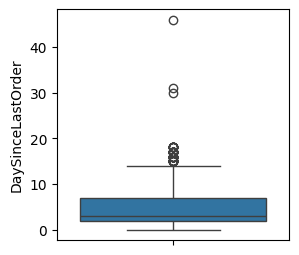

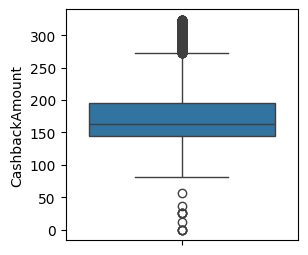

In [20]:
def check_outlier(df,nume_cols):
  for i in nume_cols:
    plt.figure(figsize=(3,3))
    sns.boxplot(df[i])
    plt.show()

check_outlier(df,nume_cols)

#### **1.7 Check distribution for categorical columns**

In [21]:
print(cate_cols)
print(false_nume)

Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus'],
      dtype='object')
['Churn', 'CityTier', 'CustomerID']


In [22]:
def plot_cate(df,cate_cols):
  for i in cate_cols:
    sns.countplot(df,x=i,hue="Churn")
    plt.show()

    pivot = df.pivot_table(index=i,columns='Churn',values='CustomerID',aggfunc='count').reset_index()
    pivot["%ChurnUser"] = pivot[0]/pivot[1]
    print(pivot.sort_values(by='%ChurnUser',ascending=False))
    print('\n')

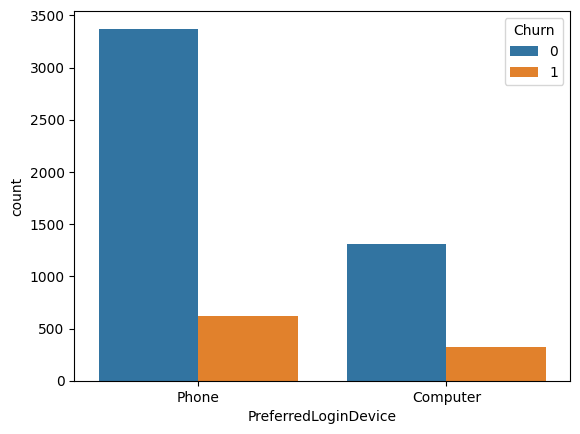

Churn PreferredLoginDevice     0    1  %ChurnUser
1                    Phone  3372  624    5.403846
0                 Computer  1310  324    4.043210




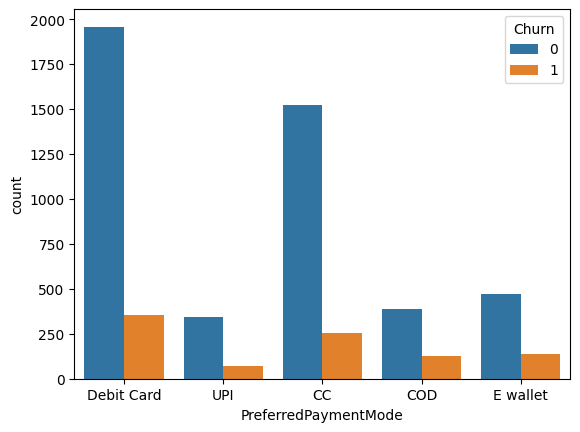

Churn PreferredPaymentMode     0    1  %ChurnUser
0                       CC  1522  252    6.039683
2               Debit Card  1958  356    5.500000
4                      UPI   342   72    4.750000
3                 E wallet   474  140    3.385714
1                      COD   386  128    3.015625




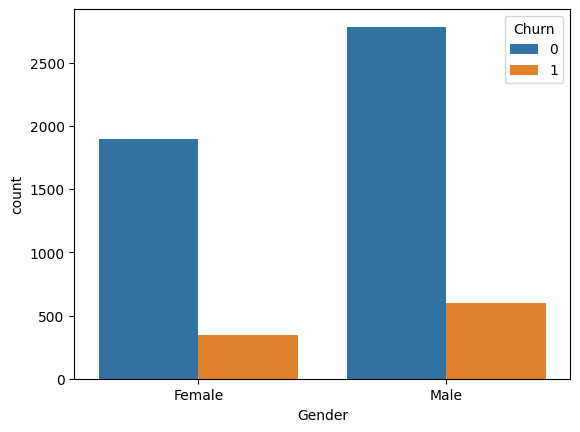

Churn  Gender     0    1  %ChurnUser
0      Female  1898  348    5.454023
1        Male  2784  600    4.640000




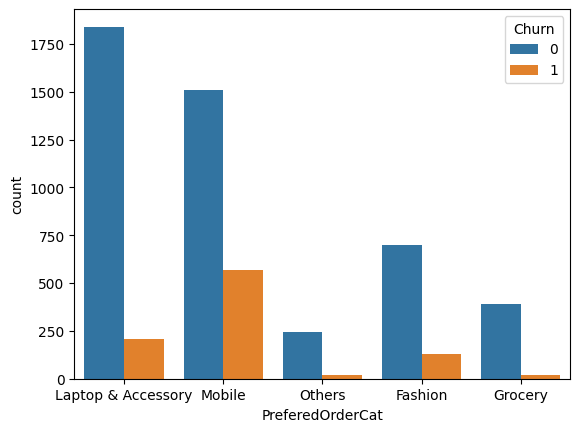

Churn    PreferedOrderCat     0    1  %ChurnUser
1                 Grocery   390   20   19.500000
4                  Others   244   20   12.200000
2      Laptop & Accessory  1840  210    8.761905
0                 Fashion   698  128    5.453125
3                  Mobile  1510  570    2.649123




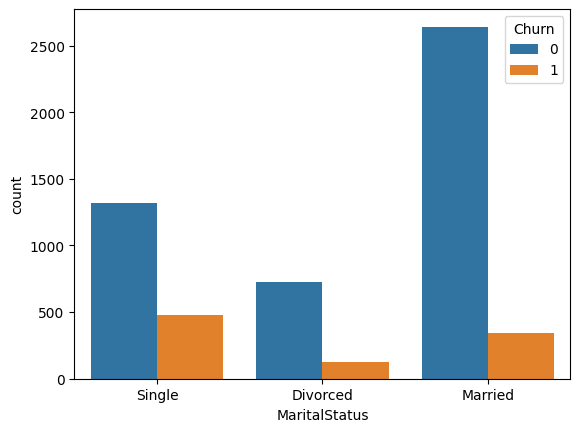

Churn MaritalStatus     0    1  %ChurnUser
1           Married  2642  344    7.680233
0          Divorced   724  124    5.838710
2            Single  1316  480    2.741667




In [23]:
plot_cate(df,cate_cols)

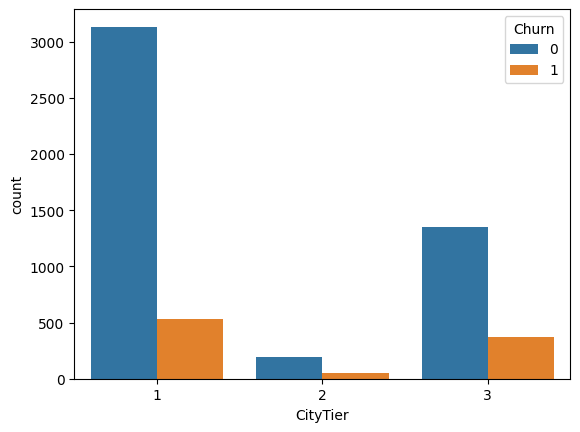

Churn  CityTier     0    1  %ChurnUser
0             1  3134  532    5.890977
1             2   194   48    4.041667
2             3  1354  368    3.679348




In [24]:
sns.countplot(df,x="CityTier",hue="Churn")
plt.show()

pivot = df.pivot_table(index="CityTier",columns='Churn',values='CustomerID',aggfunc='count').reset_index()
pivot["%ChurnUser"] = pivot[0]/pivot[1]
print(pivot.sort_values(by='%ChurnUser',ascending=False))
print('\n')

=> Tỷ lệ Churn của KH dùng Phone và Computer có sự chênh lệch nhỏ, lần lượt là 5.4% và 4%

=> Tỷ lệ Churn của KH dùng Payment Mode là Debit, Credit, UPI tương đối cao (5-6%). Trong đó, tỷ lệ KH dùng COD và E-wallet là thấp nhất (~3%)

=> Tỷ lệ Churn của KH female cao hơn male (5.4% và 4.5%) nhưng không quá khác biệt

=> Tỷ lệ Churn của KH có PreferedOrderCat là Mobile thấp nhất (~2%). Ngược lại, tỷ lệ Grocery và Others cao nhất, khác biệt hẳn(19% và 12%)

=> Tỷ lệ Churn của KH Single thấp nhất (~2.7%). Trong khi, tỷ lệ Married và Divorced là khá cao (7.6% và 5.8%)

=> Tỷ lệ Churn của KH ở city 2 và 3 tương đương nhau (~4%). Trong khi, tỷ lệ city 1 cao nhất (6%)

## **2. PICK IMPORTANT FEATURES BY RANDOM FOREST**

#### **2.1 Encode**

In [25]:
df.head(2)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4,Phone,3,6,Debit Card,Female,3,3,Laptop & Accessory,2,Single,9,1,11,1,1,5,159
1,50002,1,9,Phone,1,8,UPI,Male,3,4,Mobile,3,Single,7,1,15,0,1,0,120


In [26]:
cate_cols = df.select_dtypes('object').columns
df_dummy = pd.get_dummies(df, columns=cate_cols, drop_first=True)
df_dummy.head(2)

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,50001,1,4,3,6,3,3,2,9,1,...,True,False,False,False,False,True,False,False,False,True
1,50002,1,9,1,8,3,4,3,7,1,...,False,False,True,True,False,False,True,False,False,True


#### **2.2 Normalization: MinMaxScaler**

In [27]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_dummy)

df_scaled = pd.DataFrame(scaled_data, columns=df_dummy.columns)
df_scaled.head(2)

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,0.000000,1.0,0.065574,1.0,0.008197,0.6,0.4,0.25,0.380952,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000178,1.0,0.147541,0.0,0.024590,0.6,0.6,0.50,0.285714,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


#### **2.3 Apply Random Forest**

In [28]:
# Random Forest
x = df_scaled.drop('Churn',axis=1)
y = df_scaled['Churn']

x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, test_size=0.33,random_state=42)
clf_ranf = RandomForestClassifier()
clf_ranf.fit(x_train,y_train)

y_pred = clf_ranf.predict(x_test)
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_pred)}')

Balance accuracy of test set: 0.879482407436128


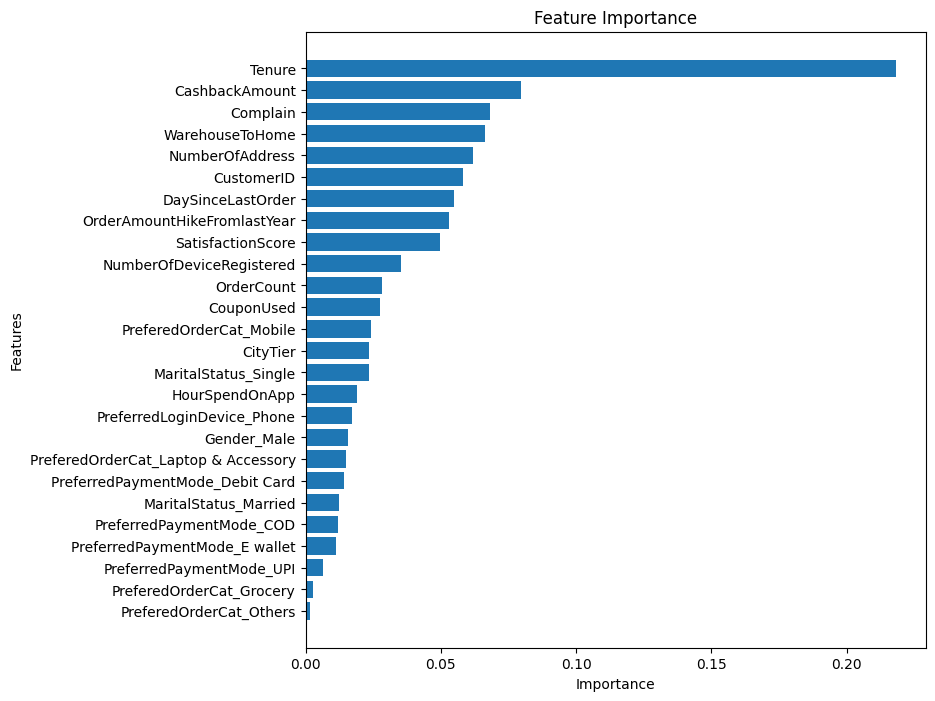

In [29]:
# Show importance features
feats = {}
for feature, importance in zip(x.columns, clf_ranf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=True)

importances = importances.reset_index()
importances

# Create bar chart
plt.figure(figsize=(8, 8))
plt.barh(importances["index"], importances["Gini-importance"])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

As Feature Importance show, we can see these features can have high relation with target columns:

- `Tenure`
- `Cashback amount`
- `Distance from warehouse to home`
- `Complain`
- `Days since Last order`
- `Satisfaction Score`

→ We will analyse and visualize these features for more insights

**@ NOTE**: `CustomerID`, `NumberOfAddress` không mang ý nghĩa đối với target columns

## **3. QUESTION 1**

#### **Analyse features from initial Random Forest model**
- `Tenure`
- `Cashback amount`
- `Distance from warehouse to home`
- `Complain`
- `Days since Last order`
- `Satisfaction Score`


In [30]:
df[["Tenure","CashbackAmount","WarehouseToHome","Complain","DaySinceLastOrder","SatisfactionScore"]].head(2)

,Tenure,CashbackAmount,WarehouseToHome,Complain,DaySinceLastOrder,SatisfactionScore
0,4,159,6,1,5,2
1,9,120,8,1,0,3


In [31]:
def count_percentage(df, column, target, count):
    '''
    This function to create the table calculate the percentage of churned/non-churned
    transaction on total transaction group by category values
    '''

    # Create 2 dataframes of fraud and non-fraud
    churn = df[df[target]==1].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)
    not_churn = df[df[target]==0].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)

    #Merge 2 dataframe into one:
    cate_df = churn.merge(not_churn, on = column , how = 'outer')
    cate_df = cate_df.fillna(0)
    cate_df.rename(columns = {count+'_x':'churn',count+'_y':'not_churn'}, inplace = True)

    #Caculate the percentage:
    cate_df['%'] = cate_df['churn']/(cate_df['churn']+cate_df['not_churn'])
    cate_df = cate_df.sort_values(by='%', ascending=False)

    return cate_df

##### **3.1 Tenure**: New users are churned more than old users

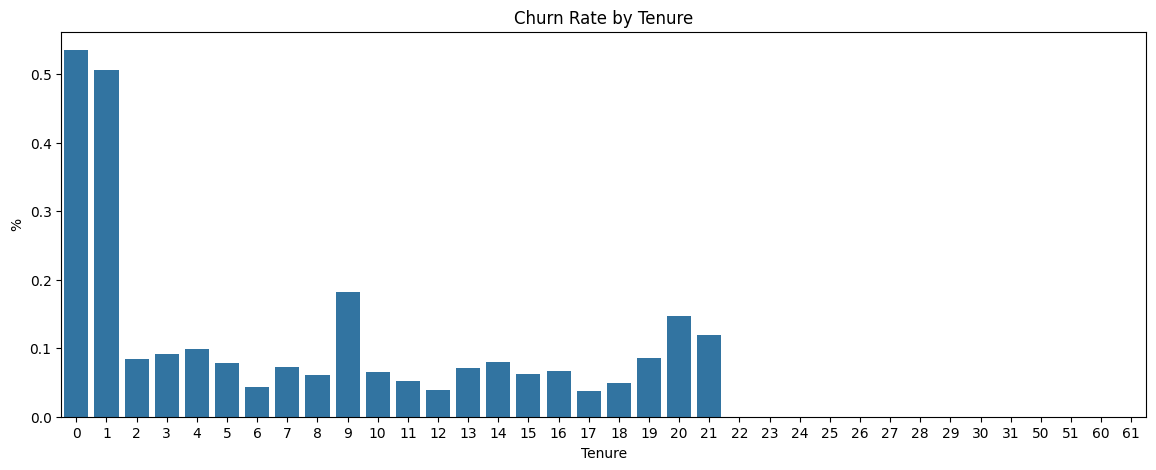

In [32]:
plot_df = count_percentage(df, 'Tenure', 'Churn', 'CustomerID')

#Visualize the churn data:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(data=plot_df, x='Tenure',y='%', ax=ax)
plt.title('Churn Rate by Tenure')

plt.show()

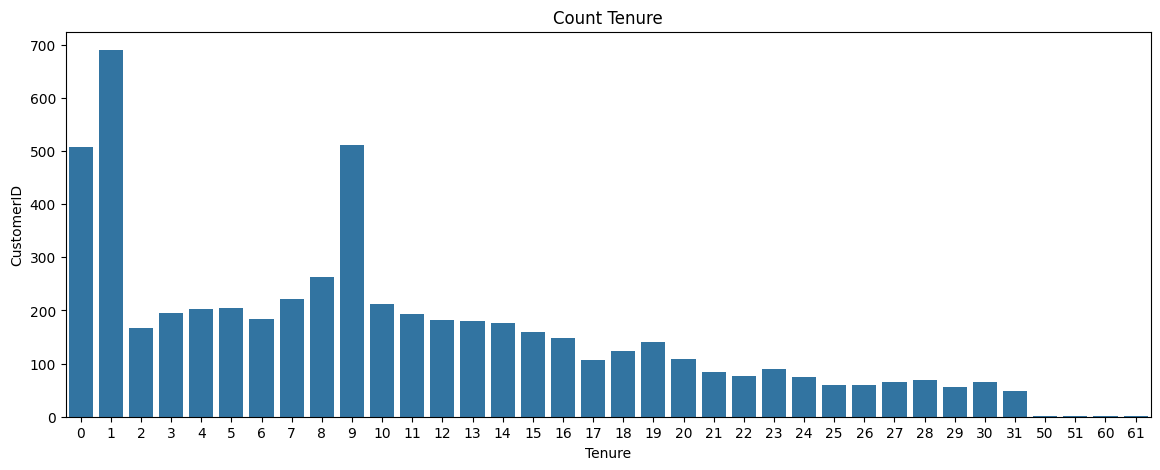

In [33]:
#Visualize the total data:
fig, ax = plt.subplots(figsize=(14, 5))
count_df = df.groupby('Tenure')['CustomerID'].count().reset_index()
sns.barplot(data=count_df, x='Tenure',y='CustomerID', ax=ax)
plt.title('Count Tenure')

plt.show()

##### **3.2 CashbackAmount**: Churned users recieved less cashbackamount than non-churned users

<Axes: xlabel='Churn', ylabel='CashbackAmount'>

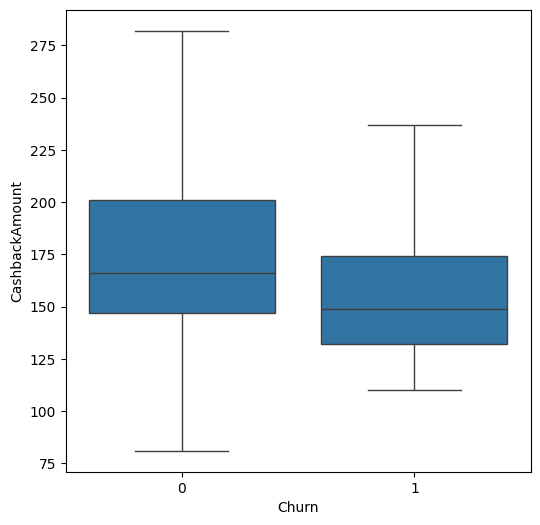

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df, x='Churn',y='CashbackAmount',ax=ax, showfliers=False)

##### **3.3 WarehouseToHome**: not significantly related

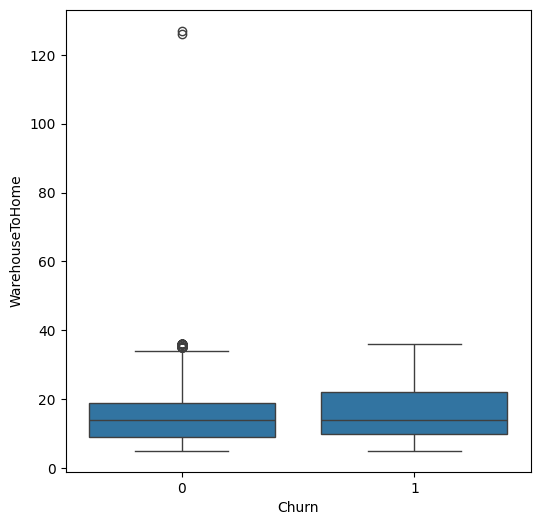

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df, x='Churn',y='WarehouseToHome',ax=ax)
plt.show()

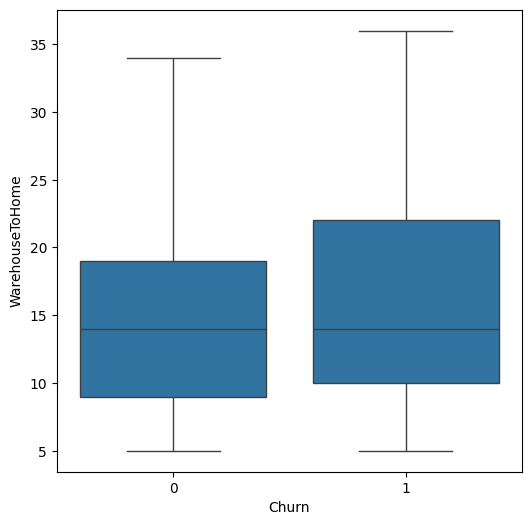

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df, x='Churn',y='WarehouseToHome',ax=ax, showfliers = False)
plt.show()

=> For both Churned and Non-churned users:
- The pt25, median, mean, pt75 are quite the same => The centralize of data is the same
- For non-churned users, it has some outliers => This can note be significant enough to consider it as an insight for not churn

→ There're no strong evidences showing that there are any differences between churn and not churn for `WarehouseToHome` --> We will exclude this features when apply model for not being bias.

##### **3.4 Complain**:
And if a user complains, the percentage of user being churned user is 30%

If a user does not complain, the percentage of user being churned user is 10%

   Complain  churn  not_churn         %
0         1    508       1096  0.316708
1         0    440       3586  0.109290


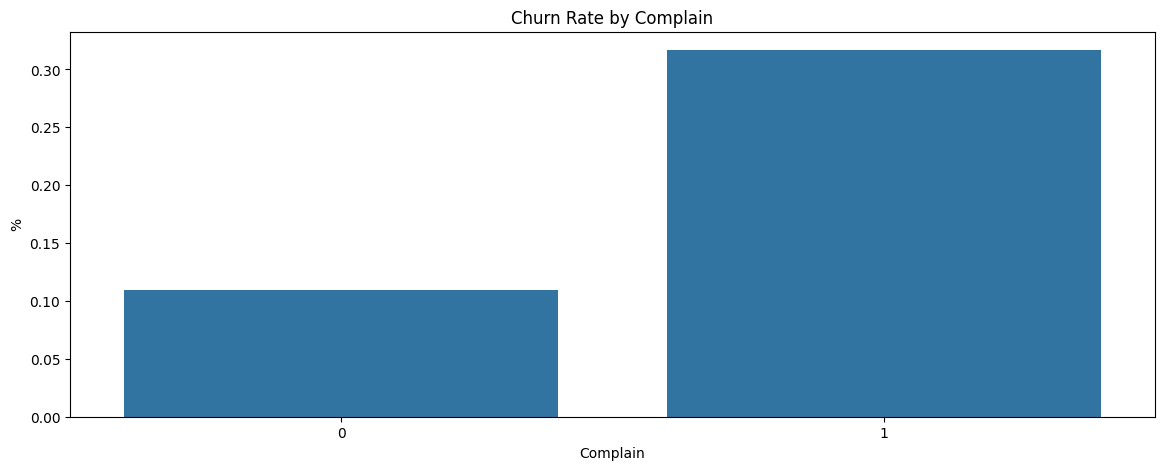

In [37]:
plot_df = count_percentage(df, 'Complain', 'Churn', 'CustomerID')
print(plot_df)
#Visualize the churn data:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(data=plot_df, x='Complain',y='%', ax=ax)
plt.title('Churn Rate by Complain')

plt.show()

##### **3.5 DaySinceLastOrder**: churn users with complain = 1 have higher days since orders than churned users with complain = 0

<Axes: xlabel='Churn', ylabel='DaySinceLastOrder'>

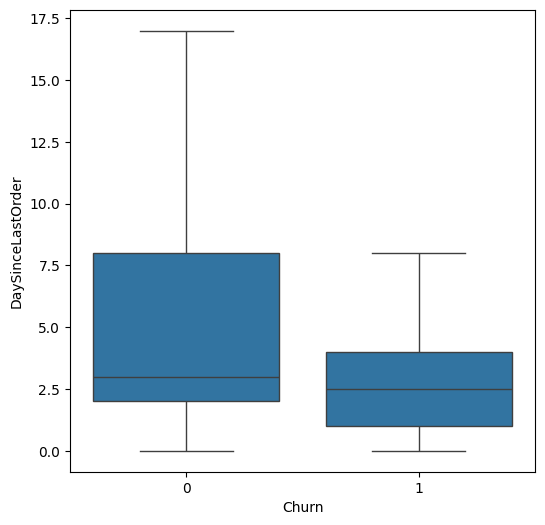

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df, x='Churn',y='DaySinceLastOrder',ax=ax, showfliers = False)

From this chart, we see for churned users that they had orders recently (the day since last order is less than non-churned users) -> This is quite strange, so we should monitor more features for this insight (SatisfactionScore, Complain...)

<Axes: xlabel='Complain', ylabel='DaySinceLastOrder'>

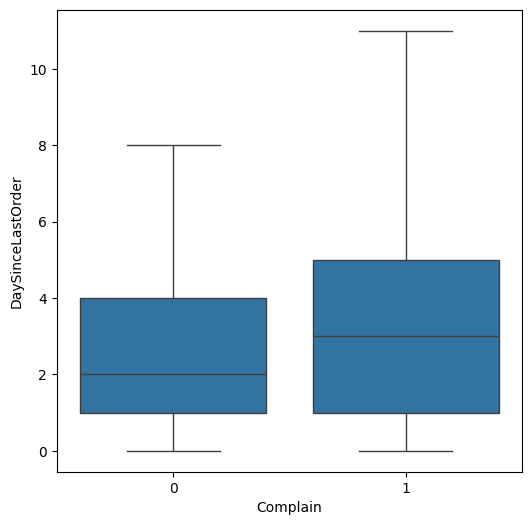

In [39]:
churn_df = df[df['Churn']==1]
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=churn_df, x='Complain',y='DaySinceLastOrder',ax=ax, showfliers = False)

##### **3.6 SatisfactionScore**: users rate high score, that means they are more likely to become churned users

   SatisfactionScore  churn  not_churn         %
1                  5    264        844  0.238267
0                  3    292       1406  0.171967
2                  4    184        890  0.171322
4                  2     74        512  0.126280
3                  1    134       1030  0.115120


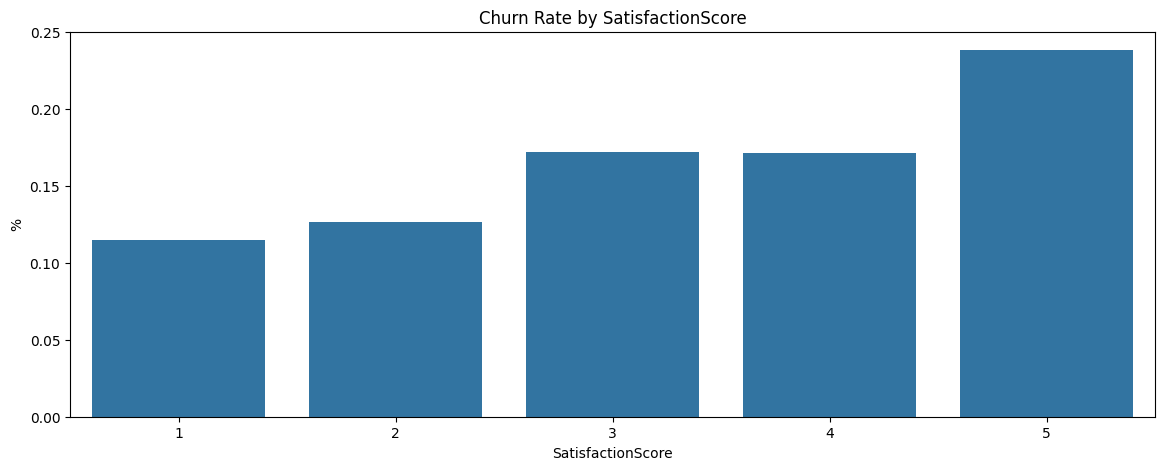

In [40]:
plot_df = count_percentage(df, 'SatisfactionScore', 'Churn', 'CustomerID')
print(plot_df)
#Visualize the churn data:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(data=plot_df, x='SatisfactionScore',y='%', ax=ax)
plt.title('Churn Rate by SatisfactionScore')

plt.show()

From this chart, we see that the more satisfaction score is, the higher percentage of being churned user is -> This is quite strange, so we should monitor more features for this insight (Tenure, CashbackAmount)

<Axes: xlabel='SatisfactionScore', ylabel='CashbackAmount'>

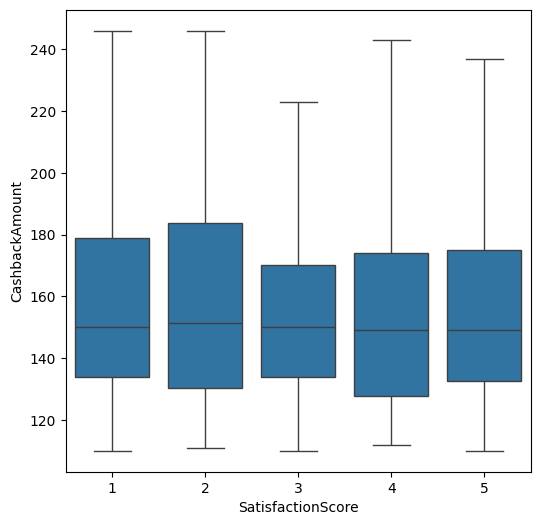

In [41]:
churn_df = df[df['Churn']==1]
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=churn_df, x='SatisfactionScore',y='CashbackAmount',ax=ax, showfliers = False)

<Axes: xlabel='SatisfactionScore', ylabel='CashbackAmount'>

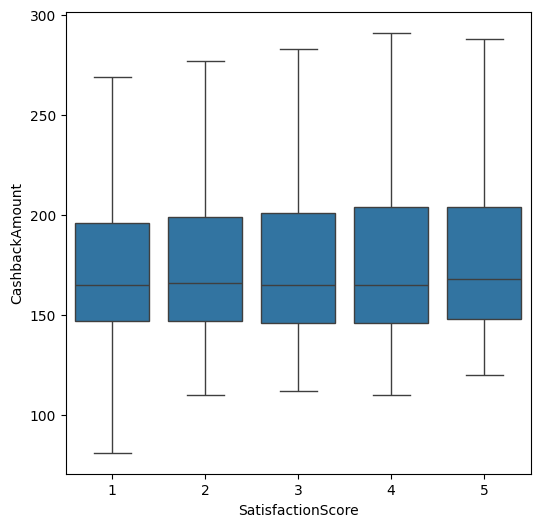

In [42]:
churn_df = df[df['Churn']==0]
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=churn_df, x='SatisfactionScore',y='CashbackAmount',ax=ax, showfliers = False)

<Axes: xlabel='SatisfactionScore', ylabel='Tenure'>

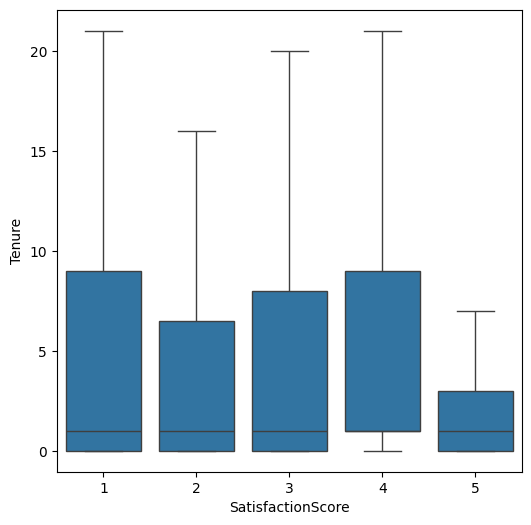

In [43]:
churn_df = df[df['Churn']==1]
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=churn_df, x='SatisfactionScore',y='Tenure',ax=ax, showfliers = False)

<Axes: xlabel='SatisfactionScore', ylabel='Tenure'>

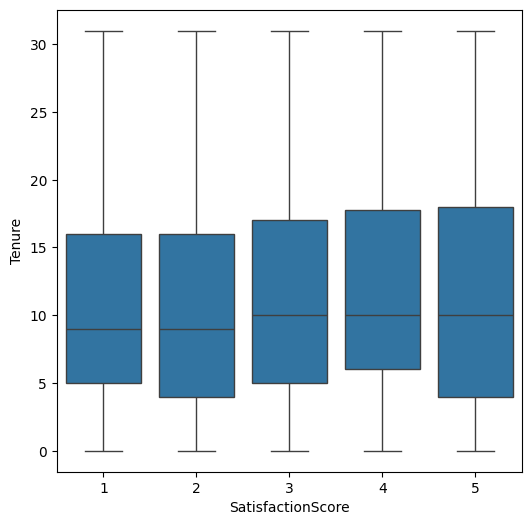

In [44]:
churn_df = df[df['Churn']==0]
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=churn_df, x='SatisfactionScore',y='Tenure',ax=ax, showfliers = False)

From 4 chart above, there is no significant differences between score 1-5 based on different dimensions

=> This is an **intersting insight "when users rate high score, that means they are more likely to become churned users"**

##### **3.7 Conclusion & Suggestion**
1. Churned users usually are new users → Provide more promotion for new users, or increase the new users experience
2. Churned users usually receive less cashback than not churn → Increase the cashback ratio
3. The percentage of complaint users being churned user is 30%, higher than non complaint users being churned user (10%) → handle complaint quickly and deep dive what these churned users complain about, and provide the solution
4. The satisfaction score is high, that can mean they are more likely to become churned user → let customer assess detail categories like: product quality, service, staff, experience... rather than total satisfaction score. From that, improving weakness

## **4. QUESTION 2**

#### **4.1 Feature transforming**

##### **4.1.1 Remove unnecessary columns**
1. `CustomerID`: this column does not affect target columns
2. `WarehouseToHome`: from the chart in 3.3, this column is not highly related target columns

In [45]:
df_model = df.drop(columns=["CustomerID","WarehouseToHome"])
df_model.head(1)

,Churn,Tenure,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,4,Phone,3,Debit Card,Female,3,3,Laptop & Accessory,2,Single,9,1,11,1,1,5,159


##### **4.1.2 Encode**

In [46]:
cate_cols = df_model.select_dtypes('object').columns
df_dummy = pd.get_dummies(df_model, columns=cate_cols, drop_first=True)
df_dummy.head(2)

,Churn,Tenure,CityTier,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1,4,3,3,3,2,9,1,11,1,...,True,False,False,False,False,True,False,False,False,True
1,1,9,1,3,4,3,7,1,15,0,...,False,False,True,True,False,False,True,False,False,True


##### **4.1.3 Normalization**

In [47]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_dummy)

df_scaled = pd.DataFrame(scaled_data, columns=df_dummy.columns)
df_scaled.head(2)

,Churn,Tenure,CityTier,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1.0,0.065574,1.0,0.6,0.4,0.25,0.380952,1.0,0.423077,0.0625,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.147541,0.0,0.6,0.6,0.50,0.285714,1.0,0.576923,0.0000,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


#### **4.2 Apply model: Random Forest, KNN model, Logistic Regression** => the best model is Random Forest (return the best score of balanced accuracy)
- Because 3 model above are not significantly affected by bell-shaped data, so we *do not need to reduce skewness*
- However, 2/3 model (except for Random) are significantly affected by imbalance data, so we must deal with imbalance data by methods: *oversampling-SMOTE*

##### **4.2.1 Split dataset**: 10% test - 20% valid - 70% train

In [48]:
x_train, x_valid_test, y_train, y_valid_test = train_test_split(df_scaled.drop('Churn',axis=1),df_scaled['Churn'],stratify=df_scaled['Churn'], test_size=0.3,random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test,y_valid_test,stratify=y_valid_test, test_size=1/3,random_state=42)

print('--------TRAIN--------')
print('Shape of x_train: ',x_train.shape)
print('Shape of y_train: ',y_train.shape)
print(y_train.value_counts(normalize=True))
print('\n')
print('--------VALID--------')
print('Shape of x_valid: ',x_valid.shape)
print('Shape of y_valid: ',y_valid.shape)
print(y_valid.value_counts(normalize=True))
print('\n')
print('--------TEST--------')
print('Shape of x_test: ',x_test.shape)
print('Shape of y_test: ',y_test.shape)
print(y_test.value_counts(normalize=True))

--------TRAIN--------
Shape of x_train:  (3941, 24)
Shape of y_train:  (3941,)
Churn
0.0    0.831515
1.0    0.168485
Name: proportion, dtype: float64


--------VALID--------
Shape of x_valid:  (1126, 24)
Shape of y_valid:  (1126,)
Churn
0.0    0.832149
1.0    0.167851
Name: proportion, dtype: float64


--------TEST--------
Shape of x_test:  (563, 24)
Shape of y_test:  (563,)
Churn
0.0    0.831261
1.0    0.168739
Name: proportion, dtype: float64


##### **4.2.2 Fix imbalance data for only train dataset: SMOTE**

In [49]:
smote = SMOTE(random_state=42)

x_train_smote, y_train_smote = smote.fit_resample(x_train,y_train)

print('--------BEFORE SMOTE--------')
print('Shape of x_train: ',x_train.shape)
print('Shape of y_train: ',y_train.shape)
print(y_train.value_counts(normalize=True))

print('\n')

print('--------AFTER SMOTE--------')
print('Shape of x_train: ',x_train_smote.shape)
print('Shape of y_train: ',y_train_smote.shape)
print(y_train_smote.value_counts(normalize=True))

--------BEFORE SMOTE--------
Shape of x_train:  (3941, 24)
Shape of y_train:  (3941,)
Churn
0.0    0.831515
1.0    0.168485
Name: proportion, dtype: float64


--------AFTER SMOTE--------
Shape of x_train:  (6554, 24)
Shape of y_train:  (6554,)
Churn
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


##### **4.2.3 KNN model**

In [50]:
knn = KNeighborsClassifier()
knn.fit(x_train_smote,y_train_smote)

y_pred = knn.predict(x_valid)
print(f'Balance accuracy of valid set: {balanced_accuracy_score(y_valid, y_pred)}')

Balance accuracy of valid set: 0.8745179086694561


##### **4.2.4 Logistic Regression**

In [51]:
knn = LogisticRegression()
knn.fit(x_train_smote,y_train_smote)

y_pred = knn.predict(x_valid)
print(f'Balance accuracy of valid set: {balanced_accuracy_score(y_valid, y_pred)}')

Balance accuracy of valid set: 0.7821201289717832


##### **4.2.5 Random Forest**: highest score of balanced accuracy

In [52]:
knn = RandomForestClassifier(random_state=42)
knn.fit(x_train_smote,y_train_smote)

y_pred_valid = knn.predict(x_valid)
y_pred_test = knn.predict(x_test)

print(f'Balance accuracy of valid set: {balanced_accuracy_score(y_valid, y_pred_valid)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_pred_test)}')

Balance accuracy of valid set: 0.9142089184778619
Balance accuracy of test set: 0.8957264957264958


#### **4.3 Hyperparameter tuning** for the best model (Random Forest)
1. n_estimators
2. max_depth
3. min_samples_split
4. min_samples_leaf
5. bootstrap

##### **4.3.1 GridSearchCV**: score of balance accuracy on test dataset increases to 0.9125 compared to 0.89 (not tuning)

In [53]:
# Define the parameter grid
random_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 30,40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(random_model, param_grid, cv=5, scoring='balanced_accuracy')

# Fit the model
grid_search.fit(x_train_smote, y_train_smote)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_
print(best_clf)

Best Parameters:  {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       random_state=42)


In [54]:
best_params = grid_search.best_params_
random_model_after = RandomForestClassifier(**best_params,random_state=42)

random_model_after.fit(x_train_smote, y_train_smote)
y_pred_train = random_model_after.predict(x_train_smote)
y_pred_valid = random_model_after.predict(x_valid)
y_pred_test = random_model_after.predict(x_test)

print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train_smote, y_pred_train)}')
print(f'Balance accuracy of valid set: {balanced_accuracy_score(y_valid, y_pred_valid)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_pred_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of valid set: 0.9089179131868566
Balance accuracy of test set: 0.9125843454790823


##### **4.3.2 RandomizedSearchCV**

In [55]:
# Define the parameter grid
random_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 30,40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use RandomizedSearchCV to find the best parameters
randomized_search = RandomizedSearchCV(random_model, param_grid, cv=5, scoring='balanced_accuracy')

# Fit the model
randomized_search.fit(x_train_smote, y_train_smote)

# Print the best parameters
print("Best Parameters: ", randomized_search.best_params_)

# Evaluate the best model on the test set
best_clf = randomized_search.best_estimator_
print(best_clf)

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}
RandomForestClassifier(bootstrap=False, max_depth=30, random_state=42)


In [56]:
best_params = randomized_search.best_params_
random_model_after = RandomForestClassifier(**best_params,random_state=42)

random_model_after.fit(x_train_smote, y_train_smote)
y_pred_train = random_model_after.predict(x_train_smote)
y_pred_valid = random_model_after.predict(x_valid)
y_pred_test = random_model_after.predict(x_test)

print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train_smote, y_pred_train)}')
print(f'Balance accuracy of valid set: {balanced_accuracy_score(y_valid, y_pred_valid)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_pred_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of valid set: 0.9115634158323593
Balance accuracy of test set: 0.9189158794421952


## **5. QUESTION 3**
- Use K-Means to clustering churn-users groups
- Find the insight between the groups

#### **5.1 Feature transforming**

##### **5.1.1 Remove unnecessary columns**
1. `CustomerID`: this column does not affect target columns
2. `WarehouseToHome`: from the chart in 3.3, this column is not highly related target columns

In [57]:
df_churn = df[df["Churn"]==1].drop(columns=["CustomerID","WarehouseToHome","Churn"])
df_churn.head(1)

,Tenure,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,4,Phone,3,Debit Card,Female,3,3,Laptop & Accessory,2,Single,9,1,11,1,1,5,159


##### **5.1.2 Encode**

In [58]:
cate_cols = df_churn.select_dtypes('object').columns
df_dummy = pd.get_dummies(df_churn, columns=cate_cols, drop_first=True)
df_dummy.head(2)

,Tenure,CityTier,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,4,3,3,3,2,9,1,11,1,1,...,True,False,False,False,False,True,False,False,False,True
1,9,1,3,4,3,7,1,15,0,1,...,False,False,True,True,False,False,True,False,False,True


##### **5.1.3 Normalization**

In [59]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_dummy)

df_scaled = pd.DataFrame(scaled_data, columns=df_dummy.columns)
df_scaled.head(2)

,Tenure,CityTier,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,0.190476,1.0,0.75,0.4,0.25,0.421053,1.0,0.423077,0.0625,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.428571,0.0,0.75,0.6,0.50,0.315789,1.0,0.576923,0.0000,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


#### **5.2 KMeans model**

##### **5.2.1 Dimension reduction PCA**: select 10 principal components contributing over 90% meaning

In [60]:
df_new = df_scaled.copy()
df_new.head(2)

,Tenure,CityTier,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,0.190476,1.0,0.75,0.4,0.25,0.421053,1.0,0.423077,0.0625,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.428571,0.0,0.75,0.6,0.50,0.315789,1.0,0.576923,0.0000,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [61]:
pca = PCA(n_components=10)
pca.fit(df_new)
PCA_ds = pd.DataFrame(pca.transform(df_new)
          , columns=(["col1","col2", "col3", "col4","col5","col6","col7","col8","col9","col10"]))

print('% Importance of Principal Components')
print(pca.explained_variance_ratio_)
PCA_ds.head(2)

% Importance of Principal Components
[0.16453447 0.15386322 0.10066117 0.09027756 0.08462224 0.07665349
 0.05662598 0.04245333 0.0377622  0.0360931 ]


,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
0,0.599677,0.982054,0.862725,-0.397354,-0.109620,-0.462740,-0.201680,-0.002385,0.452079,0.463747
1,-0.685742,0.184339,-0.592187,-0.567161,-0.427757,0.053077,-0.197607,-0.104392,0.244099,-0.369069


##### **5.2.2 Choosing k by elbow method**: choose k=4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

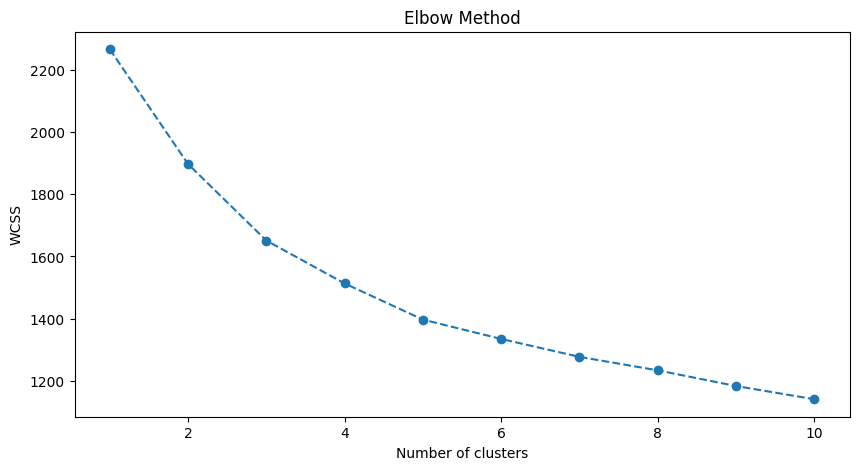

In [102]:
ss = []
max_clusters = 10
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(PCA_ds)
    # Inertia method returns WCSS for that model
    ss.append(kmeans.inertia_)

# Plot the Elbow method
plt.figure(figsize=(10,5))
plt.plot(range(1, max_clusters+1), ss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [103]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(PCA_ds)
df_churn_cop = df_churn.copy()
df_churn_cop['cluster'] = kmeans.predict(PCA_ds)

df_churn_cop.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Tenure,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,cluster
0,4,Phone,3,Debit Card,Female,3,3,Laptop & Accessory,2,Single,9,1,11,1,1,5,159,0
1,9,Phone,1,UPI,Male,3,4,Mobile,3,Single,7,1,15,0,1,0,120,1
2,9,Phone,1,Debit Card,Male,2,4,Mobile,3,Single,6,1,14,0,1,3,120,1
3,0,Phone,3,Debit Card,Male,2,4,Laptop & Accessory,5,Single,8,0,23,0,1,3,134,0
4,0,Phone,1,CC,Male,0,3,Mobile,5,Single,3,0,11,1,1,3,129,1


##### **5.2.3 Get insights**

In [104]:
df_churn_cop.head()

,Tenure,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,cluster
0,4,Phone,3,Debit Card,Female,3,3,Laptop & Accessory,2,Single,9,1,11,1,1,5,159,0
1,9,Phone,1,UPI,Male,3,4,Mobile,3,Single,7,1,15,0,1,0,120,1
2,9,Phone,1,Debit Card,Male,2,4,Mobile,3,Single,6,1,14,0,1,3,120,1
3,0,Phone,3,Debit Card,Male,2,4,Laptop & Accessory,5,Single,8,0,23,0,1,3,134,0
4,0,Phone,1,CC,Male,0,3,Mobile,5,Single,3,0,11,1,1,3,129,1


###### **Churn**: The data is distributed into 4 groups relatively evenly

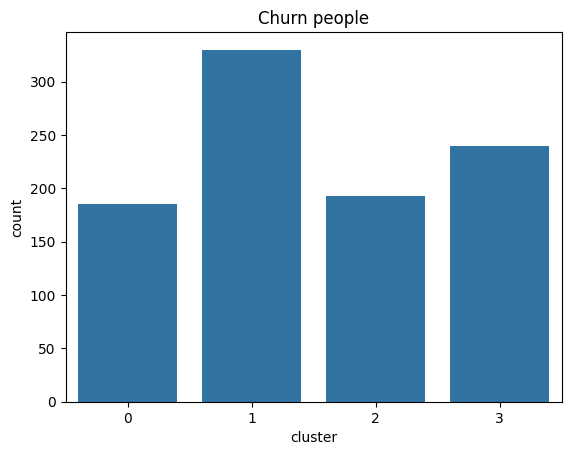

In [105]:
sns.countplot(x=df_churn_cop['cluster'])
plt.title('Churn people')
plt.show()

###### **Tenure**
**Cluster 0,2,3**
- borader IQR => more varied and longer tenures. These customers may have stayed longer before deciding to leave

**Cluster 1**
- IQR is narrow => most churned users had a relatively short tenure (new user). These customers may have churned early in their customer journey

*@ NOTE*: There are several outliers with longer tenure but no strong evidence to demonstate anything

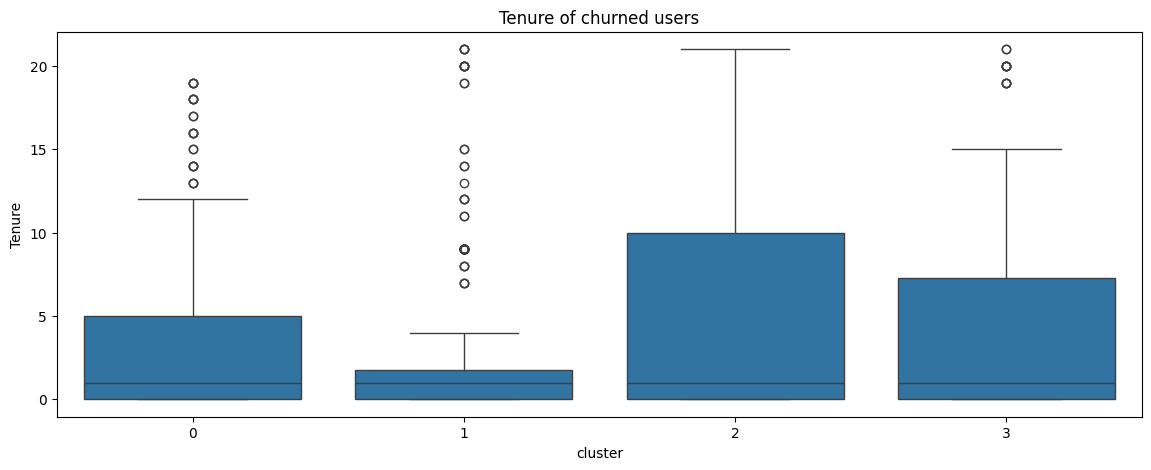

In [106]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.boxplot(data=df_churn_cop, x='cluster',y='Tenure', ax=ax)
plt.title('Tenure of churned users')

plt.show()

###### **CashbackAmount**
**Cluster 1, 3**
- several outliers with high cashback amount, but no strong evidence to demonstrate anything
- IQR is narrow => received lower cashback amount. It means that lower cashback incentives are insufficient to retain these users

**Cluster 0, 2**
- borader IQR => received higher cashback amount but still churned. It means that high cashback incentives is not enough to retain these users (they may concern other factors like quality product, service, etc)

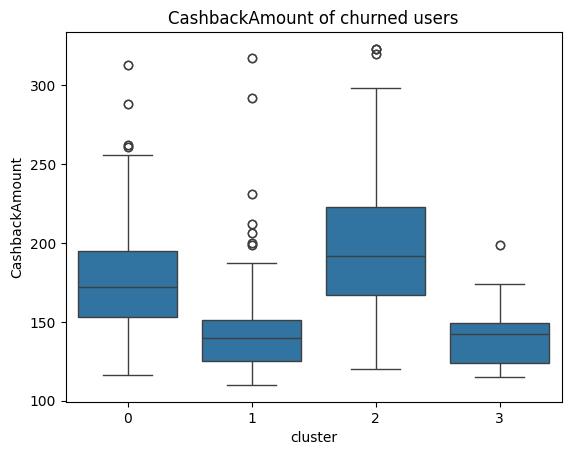

In [107]:
sns.boxplot(x=df_churn_cop['cluster'], y=df_churn_cop["CashbackAmount"])
plt.title('CashbackAmount of churned users')
plt.show()

###### **DaySinceLastOrder**
**Cluster 1, 3**
- IQR is narrow + lowest median => most users churned relatively soon after the last order.

=> Because of that, these users might be more responsive to retention efforts after the last order

**Cluster 0, 2**
- broader IQR + highest median => these users had more varied and longer gaps since the last order. It means that these users gradually disengaged from company, so it is more challenge than cluster 0,1

=> We should have marketing strategy to re-engage these users

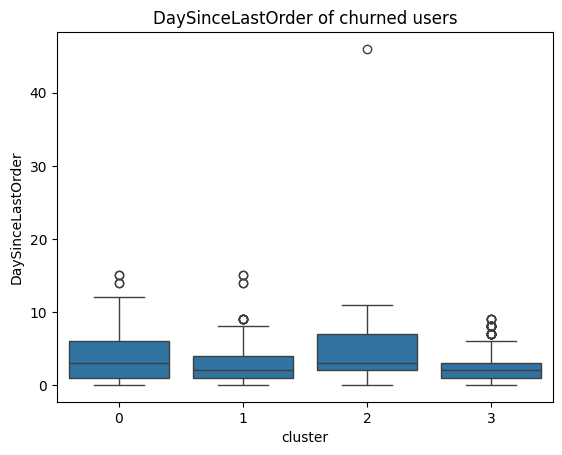

In [108]:
# DaySinceLastOrder
sns.boxplot(x=df_churn_cop['cluster'], y=df_churn_cop["DaySinceLastOrder"])
plt.title('DaySinceLastOrder of churned users')
plt.show()

###### **OrderAmountHikeFromlastYear**
**Cluster 0, 1, 3**
- relatively same IQR, no significant difference among clusters
=> These users are high-value customer (have more spending)

**Cluster 2**
- IQR is narrow => these users have less spending

=> for all clusters, the proportion of order growth is positive (10-25%). Therefore, we should remind them to buy goods

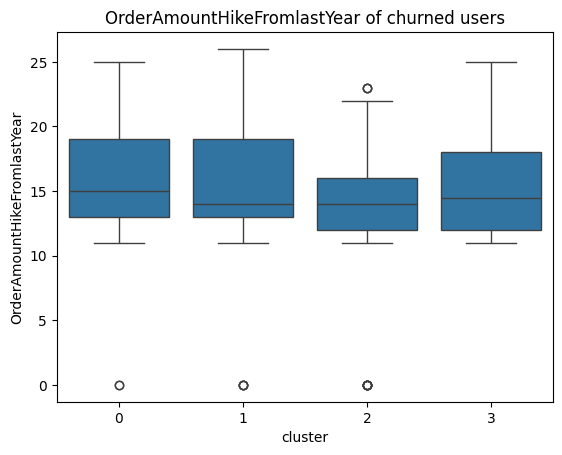

In [109]:
sns.boxplot(x=df_churn_cop['cluster'], y=df_churn_cop["OrderAmountHikeFromlastYear"])
plt.title('OrderAmountHikeFromlastYear of churned users')
plt.show()

###### **Complain**
**Cluster 0, 3**
- highest complain rate (70%) => These users reveal dissatisfactions and these complaints can be reasons for churning => This is a chance for us. If we handle complaints well, they can become loyal customers

**Cluster 1, 2**
- low complain rate (35-45%)
  - Case 1: most users do not reveal what they are dissatified with and disengaged silently => we should conduct in-depth interview to gain a deeper insights
  - Case 2: our service is not a reason for their churn (pesonal reasons) => we can not handle it

In [119]:
def count_percentage(df, column, target, count):
    '''
    This function to create the table calculate the percentage of complaint/no-complaint
    churn customer group by category values
    '''

    # Create 2 dataframes of fraud and non-fraud
    complaint = df[df[target]==1].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)
    not_complaint = df[df[target]==0].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)

    #Merge 2 dataframe into one:
    cate_df = complaint.merge(not_complaint, on = column , how = 'outer')
    cate_df = cate_df.fillna(0)
    cate_df.rename(columns = {count+'_x':'complaint',count+'_y':'not_complaint'}, inplace = True)

    #Caculate the percentage:
    cate_df['%'] = cate_df['complaint']/(cate_df['complaint']+cate_df['not_complaint'])
    cate_df = cate_df.sort_values(by='%', ascending=False)

    return cate_df

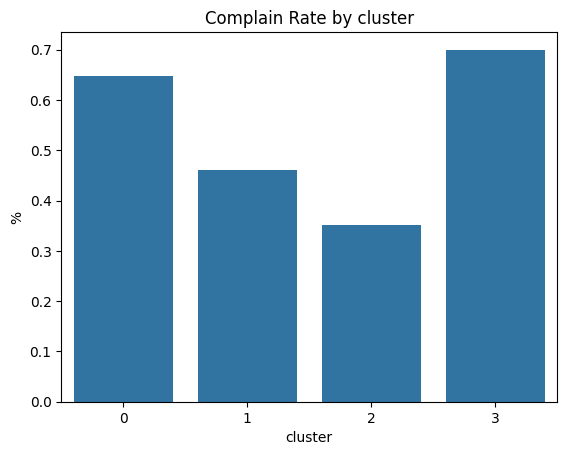

In [122]:
plot_df = count_percentage(df_churn_cop, "cluster","Complain","Complain")

#Visualize the churn data:
sns.barplot(data=plot_df, x='cluster',y='%')
plt.title('Complain Rate by cluster')

plt.show()

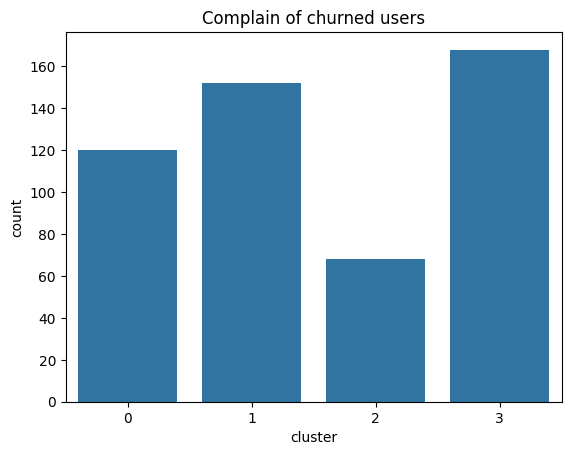

In [110]:
df_complain = df_churn_cop[df_churn_cop["Complain"]==1]

sns.countplot(data = df_complain, x=df_complain['cluster'])
plt.title('Complain of churned users')
plt.show()

###### **SatisfactionScore**
All cluster rate score around 3-3.5*, no significant differences to show unique characteristics

=> Suggestion: we should devide rating score survey into several parts: product quality, service, facility, etc

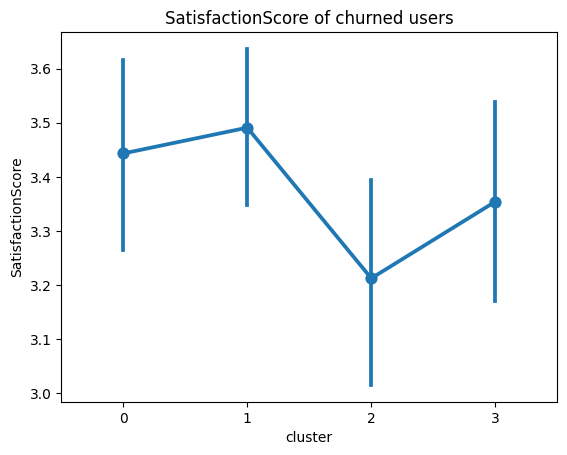

In [123]:
sns.pointplot(x=df_churn_cop['cluster'], y=df_churn_cop["SatisfactionScore"])
plt.title('SatisfactionScore of churned users')
plt.show()

###### **CouponUsed**
**Cluster 2**
- broader IQR => these user used more coupon + they have least spending (OrderAmountHikeFromlastYear). Therefore, they are highly price-sensitive and concern more about promotions, coupons, etc

**Cluster 0, 1, 3**
- IQR is narrow => these user used less coupon. There are 2 case:
  + **cluster 0, 3** have stayed longer before deciding to leave (Tenure). It means that they do not concern promotions, coupons, etc. The reason they leave might be product quality, service, etc
  + **cluster 1** had a relatively short tenure. It means that they are attrated by promotions and easily churn after ending the promotions


=> Overall, because the number of coupon used is around 2, company was not successful in driving engagement and encouraging repeat purchases. This might be a reason for churning.

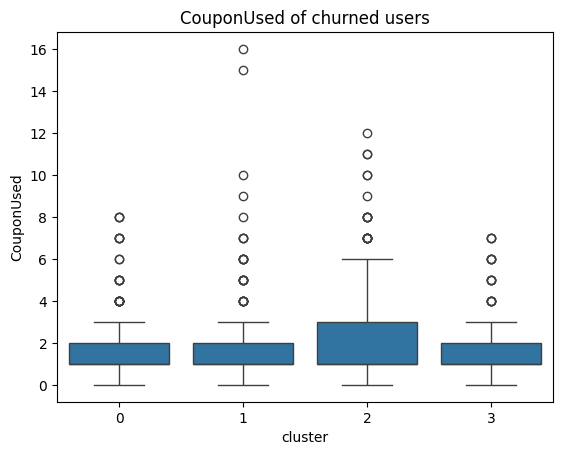

In [113]:
sns.boxplot(x=df_churn_cop['cluster'], y=df_churn_cop["CouponUsed"])
plt.title('CouponUsed of churned users')
plt.show()

###### **CityTier**
**Cluster 0, 1**: most live in city 1

**Cluster 2, 3**: most live in city 3

=> The number of churn customers live in city 2 is lowest

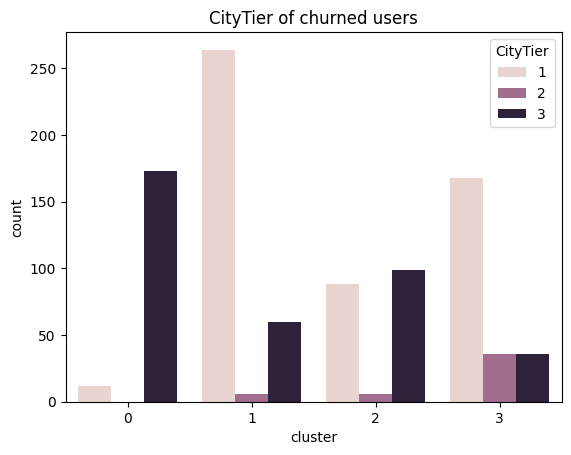

In [114]:
sns.countplot(x=df_churn_cop['cluster'], hue=df_churn_cop["CityTier"])
plt.title('CityTier of churned users')
plt.show()

###### **HourSpendOnApp**
- All cluster have same IQR, median and there is no strong evidence or outliers to demonstrate unique characteristic of each cluster => no insights get from this chart

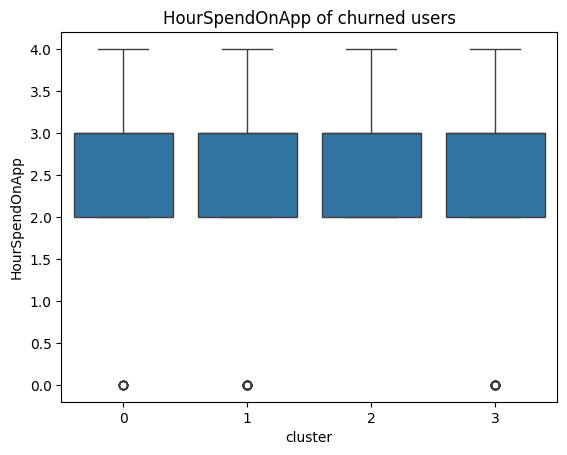

In [115]:
sns.boxplot(x=df_churn_cop['cluster'], y=df_churn_cop["HourSpendOnApp"])
plt.title('HourSpendOnApp of churned users')
plt.show()

#### **5.3 Conclusion**
**Cluster 0**
- old user, around 200
- high-value customer
- no order longer days. Disengage gradually
- live city 1
- high complain rate (70%)
- concern more about product quality, service, etc rather than promotions

**Cluster 1**
- new user, over 350
- high-value customer
- recent order. Be easily responsive to retention efforts
- live city 1
- low complain rate (45%). Disengage gradually, silently
- be attracted by promotions, coupons, cashback intensitive, etc but immediately churn after ending promotions

**Cluster 2**
- old user, around 200
- medium-value customer
- no order longer days. Disengage gradually
- live city 3
- low complain rate (35%). Disengage gradually, silently
- highly price-sensitive. Concern more about promotions, coupons, etc

**Cluster 3**
- old user, around 200
- high-value customer
- recent order. Be easily responsive to retention efforts
- live city 3
- high complain rate (70%)
- concern more about product quality, service, etc rather than promotions